ECE:5450 Machine Learning
Project Part 1
Ryan McDaniel

High Level Overview:



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import platform
import pickle
import get_data as gd

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'text.color': "white"})
plt.rcParams['figure.figsize'] = [24, 6]
plt.rcParams['axes.facecolor'] = 'black'

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extract Features from Entire Dataset

In [2]:
import get_features as gf
from skimage import color, filters
from sklearn.preprocessing import MinMaxScaler

x_train, y_train, x_val, y_val, x_test, y_test = gd.get_CIFAR10_data()

x_train_features= x_train
x_val_features  = x_val
x_test_features = x_test

print(x_train_features.shape)
print(x_val_features.shape)




(49000, 3072)
(1000, 3072)


Validation Set Grid Search to Optimize Hyperparameters Quickly

I chose this approach because I saw that not only can a grid search optimize hyperparameters, but I can also perform a PCA and and reduce the dimensionality of my dataset and increase runtime performance.  Doing both of these at the same time comes with an additional bonus to speed.

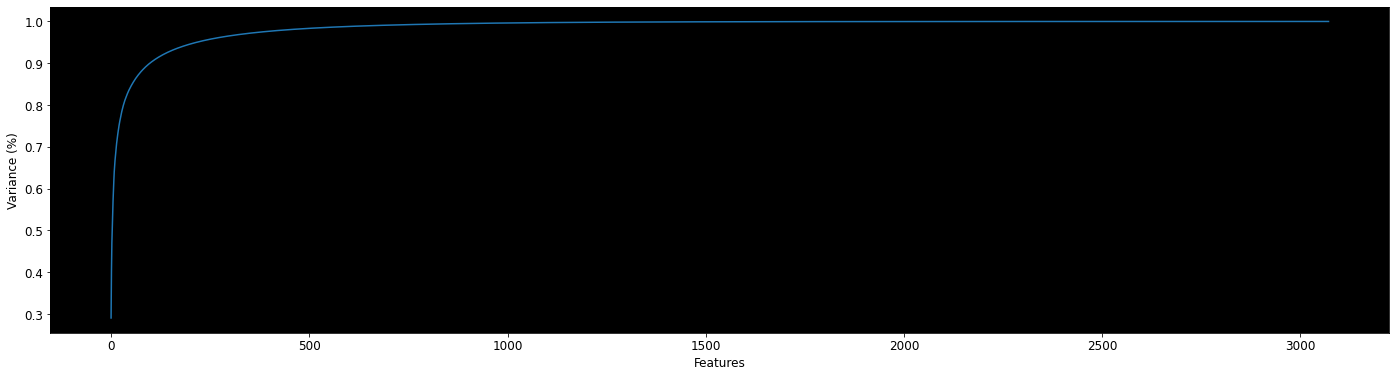

Wall time: 1min 23s
{'svc__C': 1, 'svc__gamma': 0.0001}


In [3]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA().fit(x_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Features')
plt.ylabel('Variance (%)')
plt.show()

pca = RandomizedPCA(n_components=500, whiten=True, random_state=42)

svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(x_val_features, y_val)
print(grid.best_params_)



By plotting the variance, I can see that I should probably choose 500 for my PCA components.  This number of features will retain the most variance while also cutting down on run time.

Develop Model on Training Data

In [4]:
# Reduce dimension of non validation sets
x_train_PCA = pca.fit_transform(x_train_features)
x_test_PCA = pca.fit_transform(x_test_features)

svc = SVC(kernel='linear', class_weight='balanced', C = grid.best_params_['svc__C'], gamma = grid.best_params_['svc__gamma'])
%time model = model.fit(x_train_PCA, y_train)

%time y_fit = model.predict(x_test_PCA)
np.shape(model)

Wall time: 3h 36min 7s
Wall time: 2min 57s


(2,)

Evaluate Model

Text(699.0200000000001, 0.5, 'predicted label')

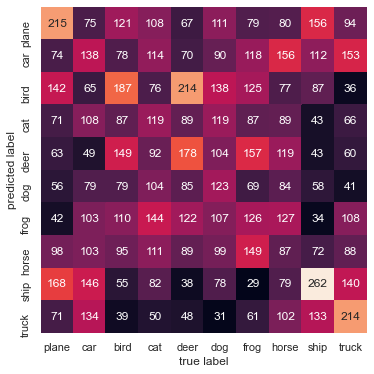

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit,
                            target_names=classes))

precision    recall  f1-score   support

       plane       0.19      0.21      0.20      1000
         car       0.13      0.14      0.13      1000
        bird       0.16      0.19      0.17      1000
         cat       0.14      0.12      0.13      1000
        deer       0.18      0.18      0.18      1000
         dog       0.16      0.12      0.14      1000
        frog       0.12      0.13      0.12      1000
       horse       0.09      0.09      0.09      1000
        ship       0.24      0.26      0.25      1000
       truck       0.24      0.21      0.23      1000

    accuracy                           0.16     10000
   macro avg       0.16      0.16      0.16     10000
weighted avg       0.16      0.16      0.16     10000



These results were ran with the original data features with a linear kernel.  I am a little disappointed with the results because I thought my validation set grid search would make this a bit more accurate than this.  Now that I have set up a decent pipeline to feed the SVM algorithm, I will begin finding if there are better features.